In [17]:
import numpy as np
import scipy as sp
import scipy.sparse
import pandas as pd
import os

# conda install scvi-tools -c bioconda -c conda-forge

import anndata as ad

import scanpy as sc
import scvi

import matplotlib.pyplot as plt

import hummingbird as hbdx
from hummingbird.io import print, rule


def apply_preprocessing(adata, feature_selection=False, n_top_genes=2**14):
    
    adata = adata.copy()
    adata.layers["counts"] = adata.raw.X
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts > 5, :] # filtering out low gene count?

#     hbdx.pipeline.StandardScaler().fit_transform(adata)
    adata = adata.copy()
    hvg_selector = hbdx.pipeline.HVGSelector(n_top_genes=n_top_genes, batch_key="batch")
    adata = hvg_selector.fit_transform(adata)
    
    sc.pp.scale(adata)
    return adata

def filt(_ad, col, val):
    # Filter out small batches
    _indx = _ad.obs.groupby(col).filter(lambda x: len(x) > val).index
    _ad = _ad[_indx, :]
    return _ad

def settting_nans_to_cat(anndata):
    blep = ["Gender", "Diagnosis_Group"]

    copy_data = anndata.copy()
    for column in blep:
        the_union = {"nan"}.union(copy_data.obs[column].cat.categories)

        copy_data.obs[column] = copy_data.obs[column].cat.set_categories(the_union)
        copy_data.obs[column].fillna("nan", inplace=True)

    return copy_data

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Generative models


We will only talk about 

## What is a distribution!

Before we talk about generative models we need to talk about data.

And in specific we need to talk about distributions. 

### Q: What is the distribution we are working with?

### A: Sequenced blood samples from all human beings

### Q: What are the variables/parameters for this distribution?

### A: Age, Gender, Cancer status, Time of day, Hospital, Nurse, Sequencer, Sample deterioration, etc. etc. etc.


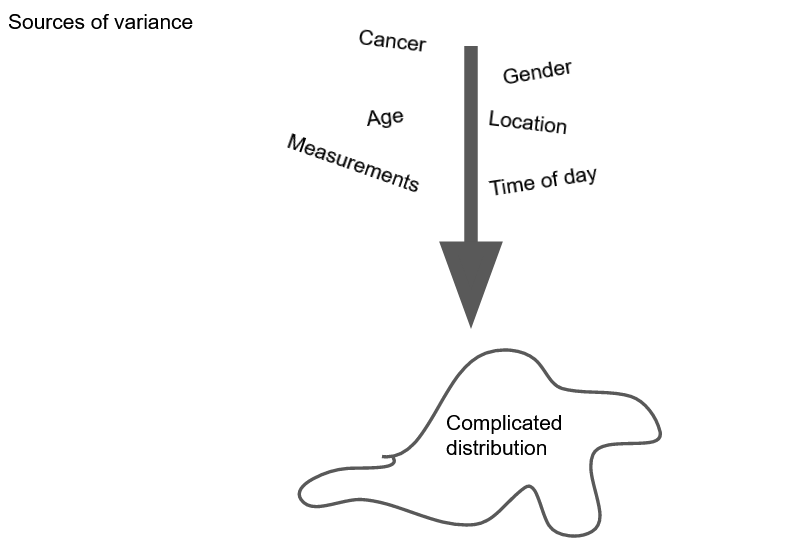




Say that we wanted to model this distribution. Then that's not easy, since the data distribution looks very complicated, and we have so many sources of variance to account for! But we can try

In generative models we speak of the distribution as p(x). Sometimes you want to condition the distribution to a specific subset, like p(x|z), with z being something like gender. 

Note! Generative models do not work with targets. This is a fundamentally different problem.  



#### Say that we have some data...

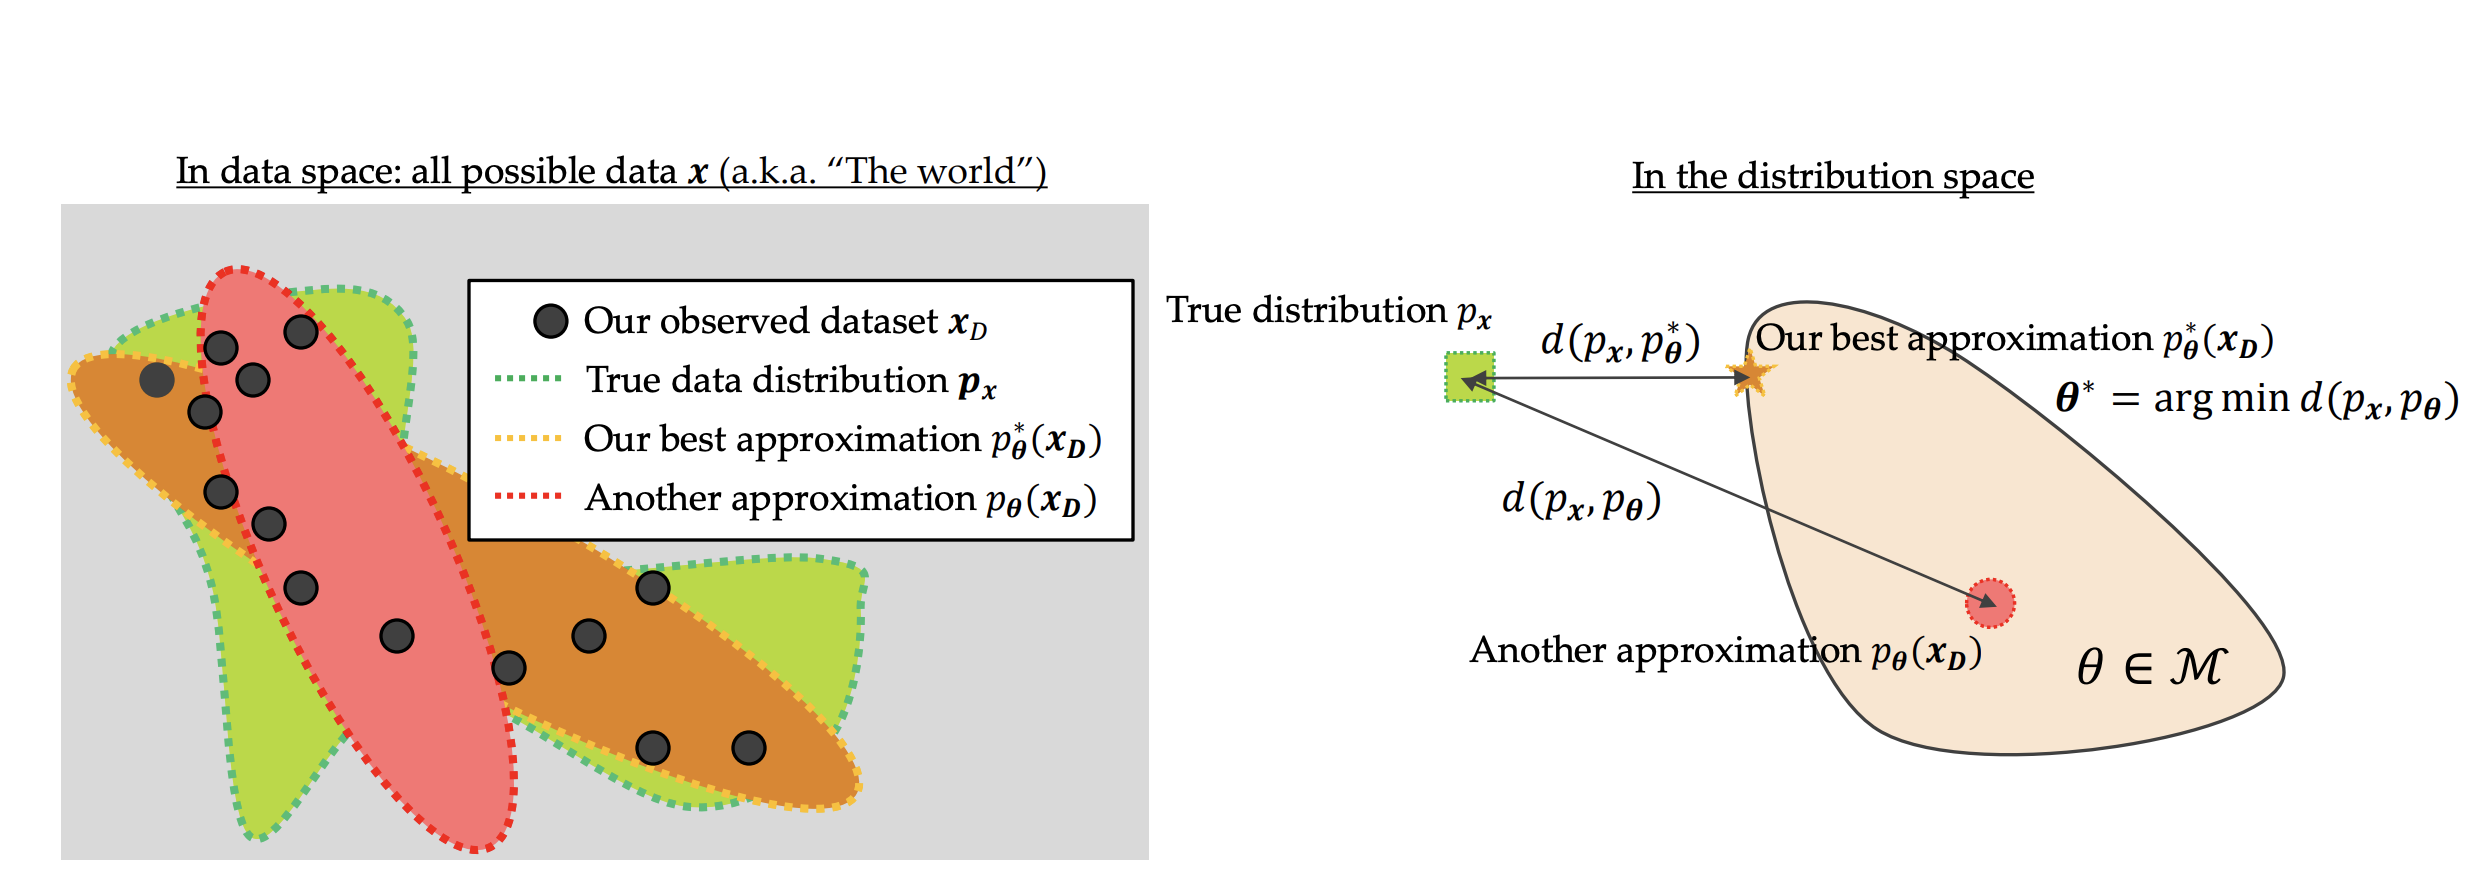

## Why use these generative models?

- Uncertainty calculation

- Calculate the probability of data (Outlier Rejection)

- Simulated Data generation

- Feature learning (on the latent)

(most of these only apply to VAE)


### This is different from classification models

Classification models do not inherently care about how the data is distributed. They aim to find decision boudaries

#### The importance of I.I.D

IID stands for independently identically distributed data. Our data is, for all intents and purposes, indepedent. However it is not identically distributed.

For one we are actively sampling patients with cancer. Second we are sampling from various different distributions, most important of which 'batch'. 

This influences how our distribution looks like! More on this later


### Demo GAN

Today we will only look at GANs and VAEs, they are the most influencial generative models and they are very different. 

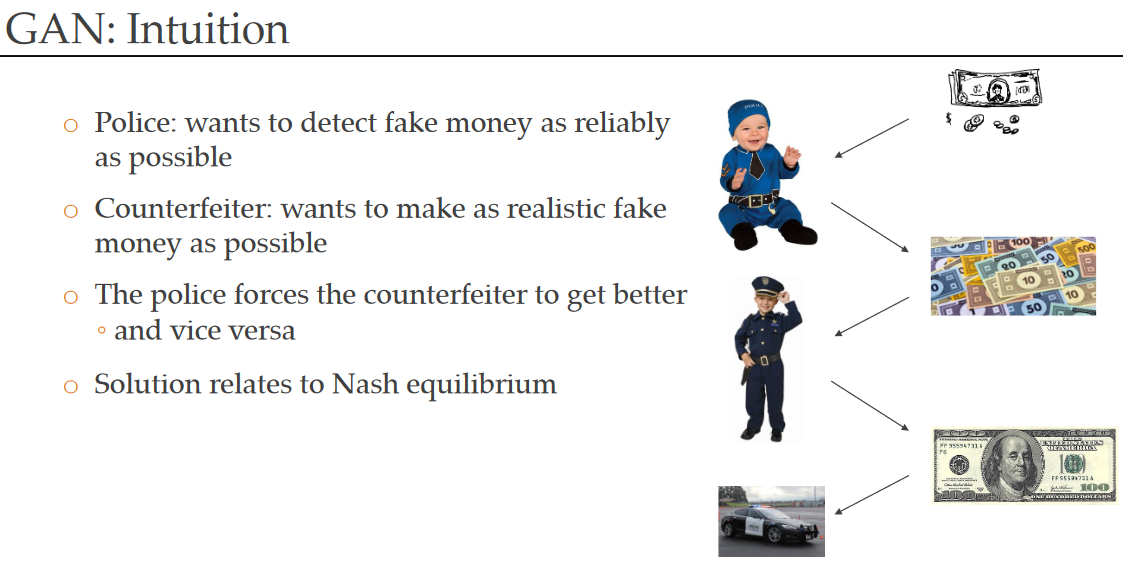

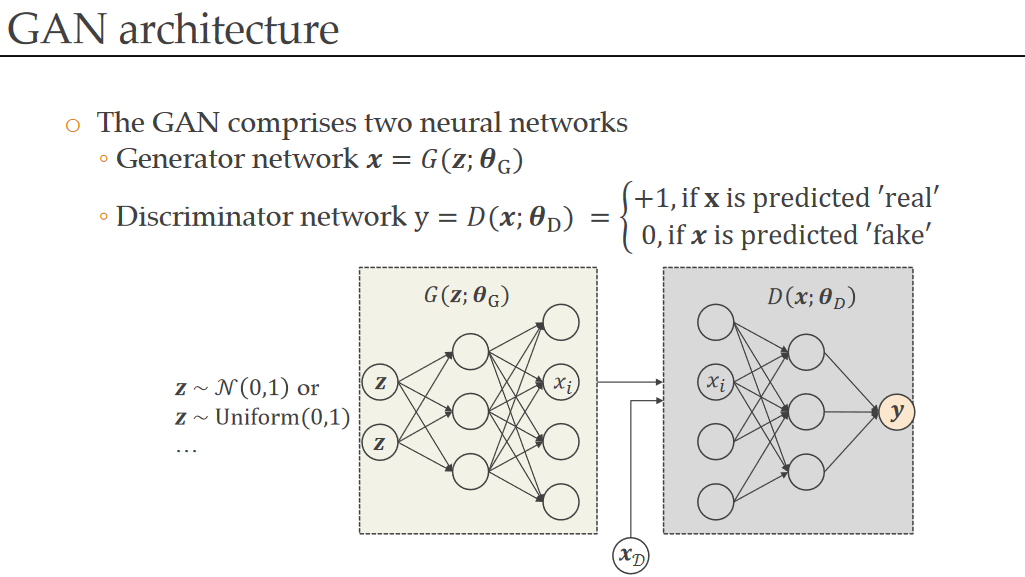

#### Randomly sampled images

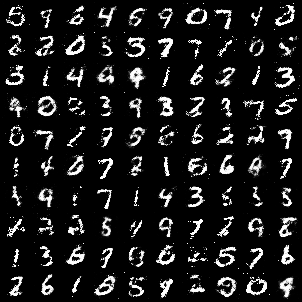

#### interpolation (walking) between 2 generated images

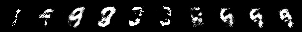

#### Demo VAE

The big takeaway is to understand the difference between Variational auto encoders and Autoencoders.

An autoencoder is a supression tool. It encodes/compresses to a lower dimension and outputs the same data. The process is deterministic. A variational autoencoder introduces smoothness through its generative properties. The lower dimension is called a latent distribution which is modelled on the data distribution.



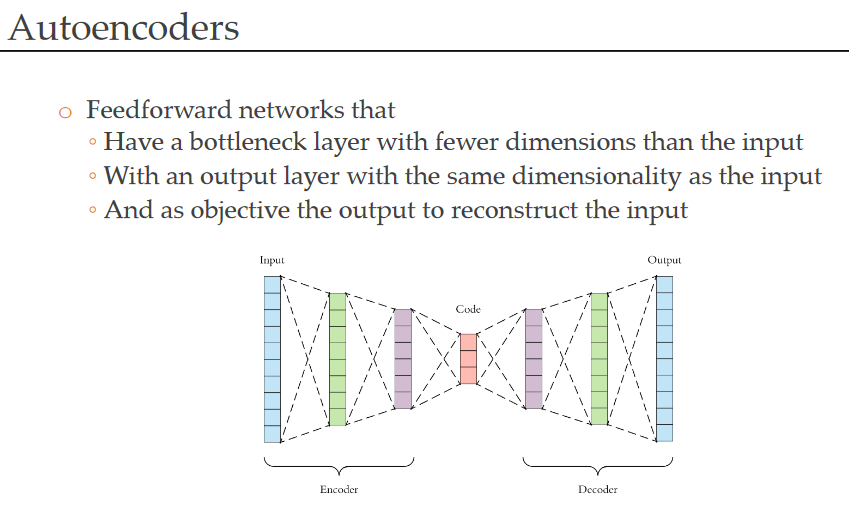

Variational aspect comes from the latent being a distribution. The Encoder gives the parameters for this distribution (mean and variance)

#### Loss

The loss is calculated with two terms. The Reconstruction loss and the ELBO. 

The reconstruction loss compares the output of the decoder with the input of the Encoder.

The EBLO term is intuitively the 'distance' between the distribution from the data and the prior (a unit normal)

The ELBO term regularizes the latent to be smooth and have variational properties. The reconstruction loss makes sure the latents contain useful information. 

##### Properties of the latent

If you would plot the latent dimension you would notice that it has some interesting properties!

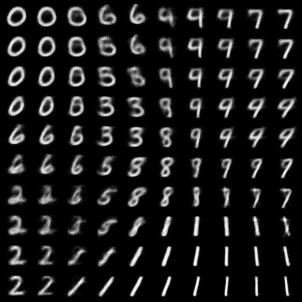

### interpolation between two points in the latent

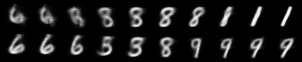

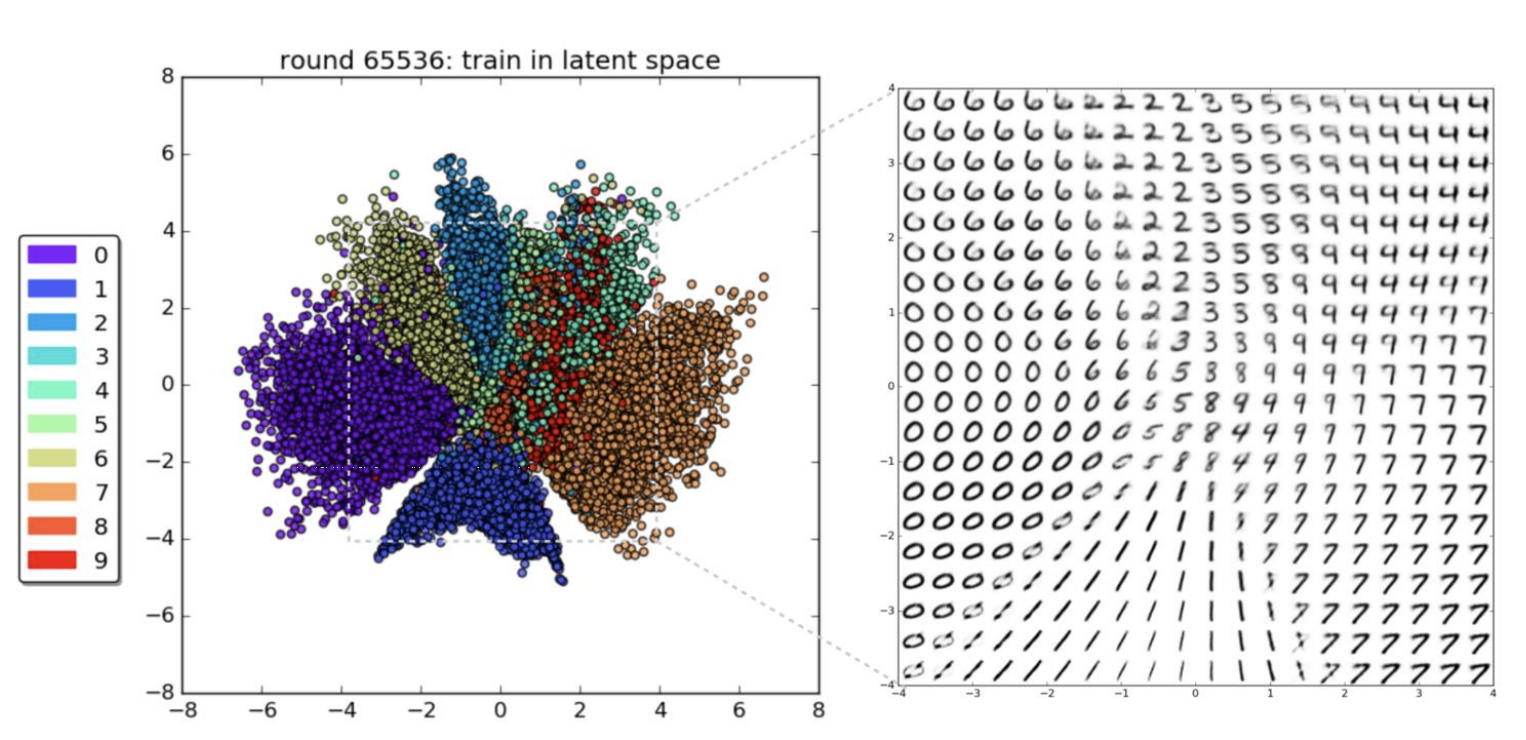

### Question: What is the latent capturing?

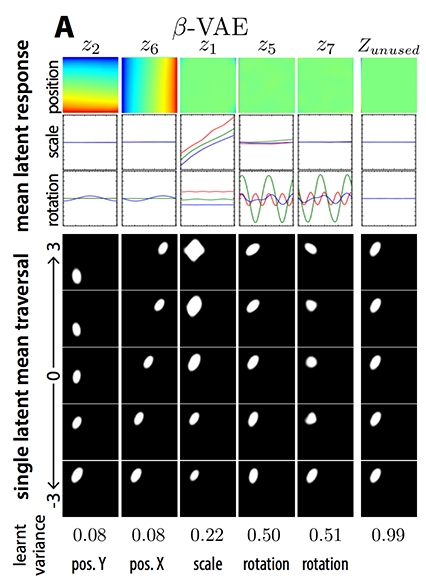

### SCVI tools

Single cell variational inference


Single cell research BUT! They are fully integrated with anndata so it is actually quite useful.

The goal is to remove unwanted variance (batch effect) while retaining relevant variance (cell type)

Let's take a look at how their models operate!

In [6]:
adata_path = "/data/hbdx/data/LC__ngs__rpm_log-21.5.0"

n_features = 2**14

sc.set_figure_params(figsize=(8,8))

adata = hbdx.io.load(adata_path)
adata.obs["batch"] = adata.obs["Lab_Multiplexing_pool_ID"]

adata = filt(adata, "Lab_Multiplexing_pool_ID", 10)
# adata.obs.groupby(["Sequencer","Lab_RNA_extr_protocol"]).batch.value_counts().unstack([0,1]).plot.barh()
adata = settting_nans_to_cat(adata)

holdout_batches = np.random.choice(adata.obs.batch.unique().categories, 2, replace=False)
adata.obs["heldout"] = np.where(adata.obs["batch"].isin(holdout_batches),"Held_Out", "Held_In")


ref_adata = adata[~adata.obs.batch.isin(holdout_batches),:].copy()
ref_adata = apply_preprocessing(ref_adata, feature_selection=True, n_top_genes=n_features) 

local cache: /home/mah/.aws_cache False


/home/mah/conda/envs/hbdx/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
new_adata = adata[adata.obs.batch.isin(holdout_batches), :].copy()
new_adata.layers["counts"] = new_adata.raw.X

new_adata = new_adata[:, ref_adata.var_names].copy()
sc.pp.scale(new_adata)
# new_adata = hbdx.pipeline.StandardScaler().fit_transform(adata)

print("Heldout batches are: ", holdout_batches)

Heldout batches are:  ['201120_454A_P2' '210220_471-468_P5']

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 647 cells, 16384 vars, 25 batches,
         1 labels, and 0 proteins. Also registered 5 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]             

{'reconstruction_loss': -58913.11224884081}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 461/1200:  38%|███▊      | 461/1200 [00:36<00:59, 12.47it/s, loss=2.36e+04, v_num=1]


{'reconstruction_loss': -18659.895382534774}

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs']                                                                         
INFO     Successfully registered anndata object containing 126 cells, 16384 vars, 27 batches,
         1 labels, and 0 proteins. Also registered 5 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scvi/model/base/_archesmixin.py:93: UserWarning: Query integration should be performed using models trained with version >= 0.8
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Training: 0it [00:00, ?it/s]


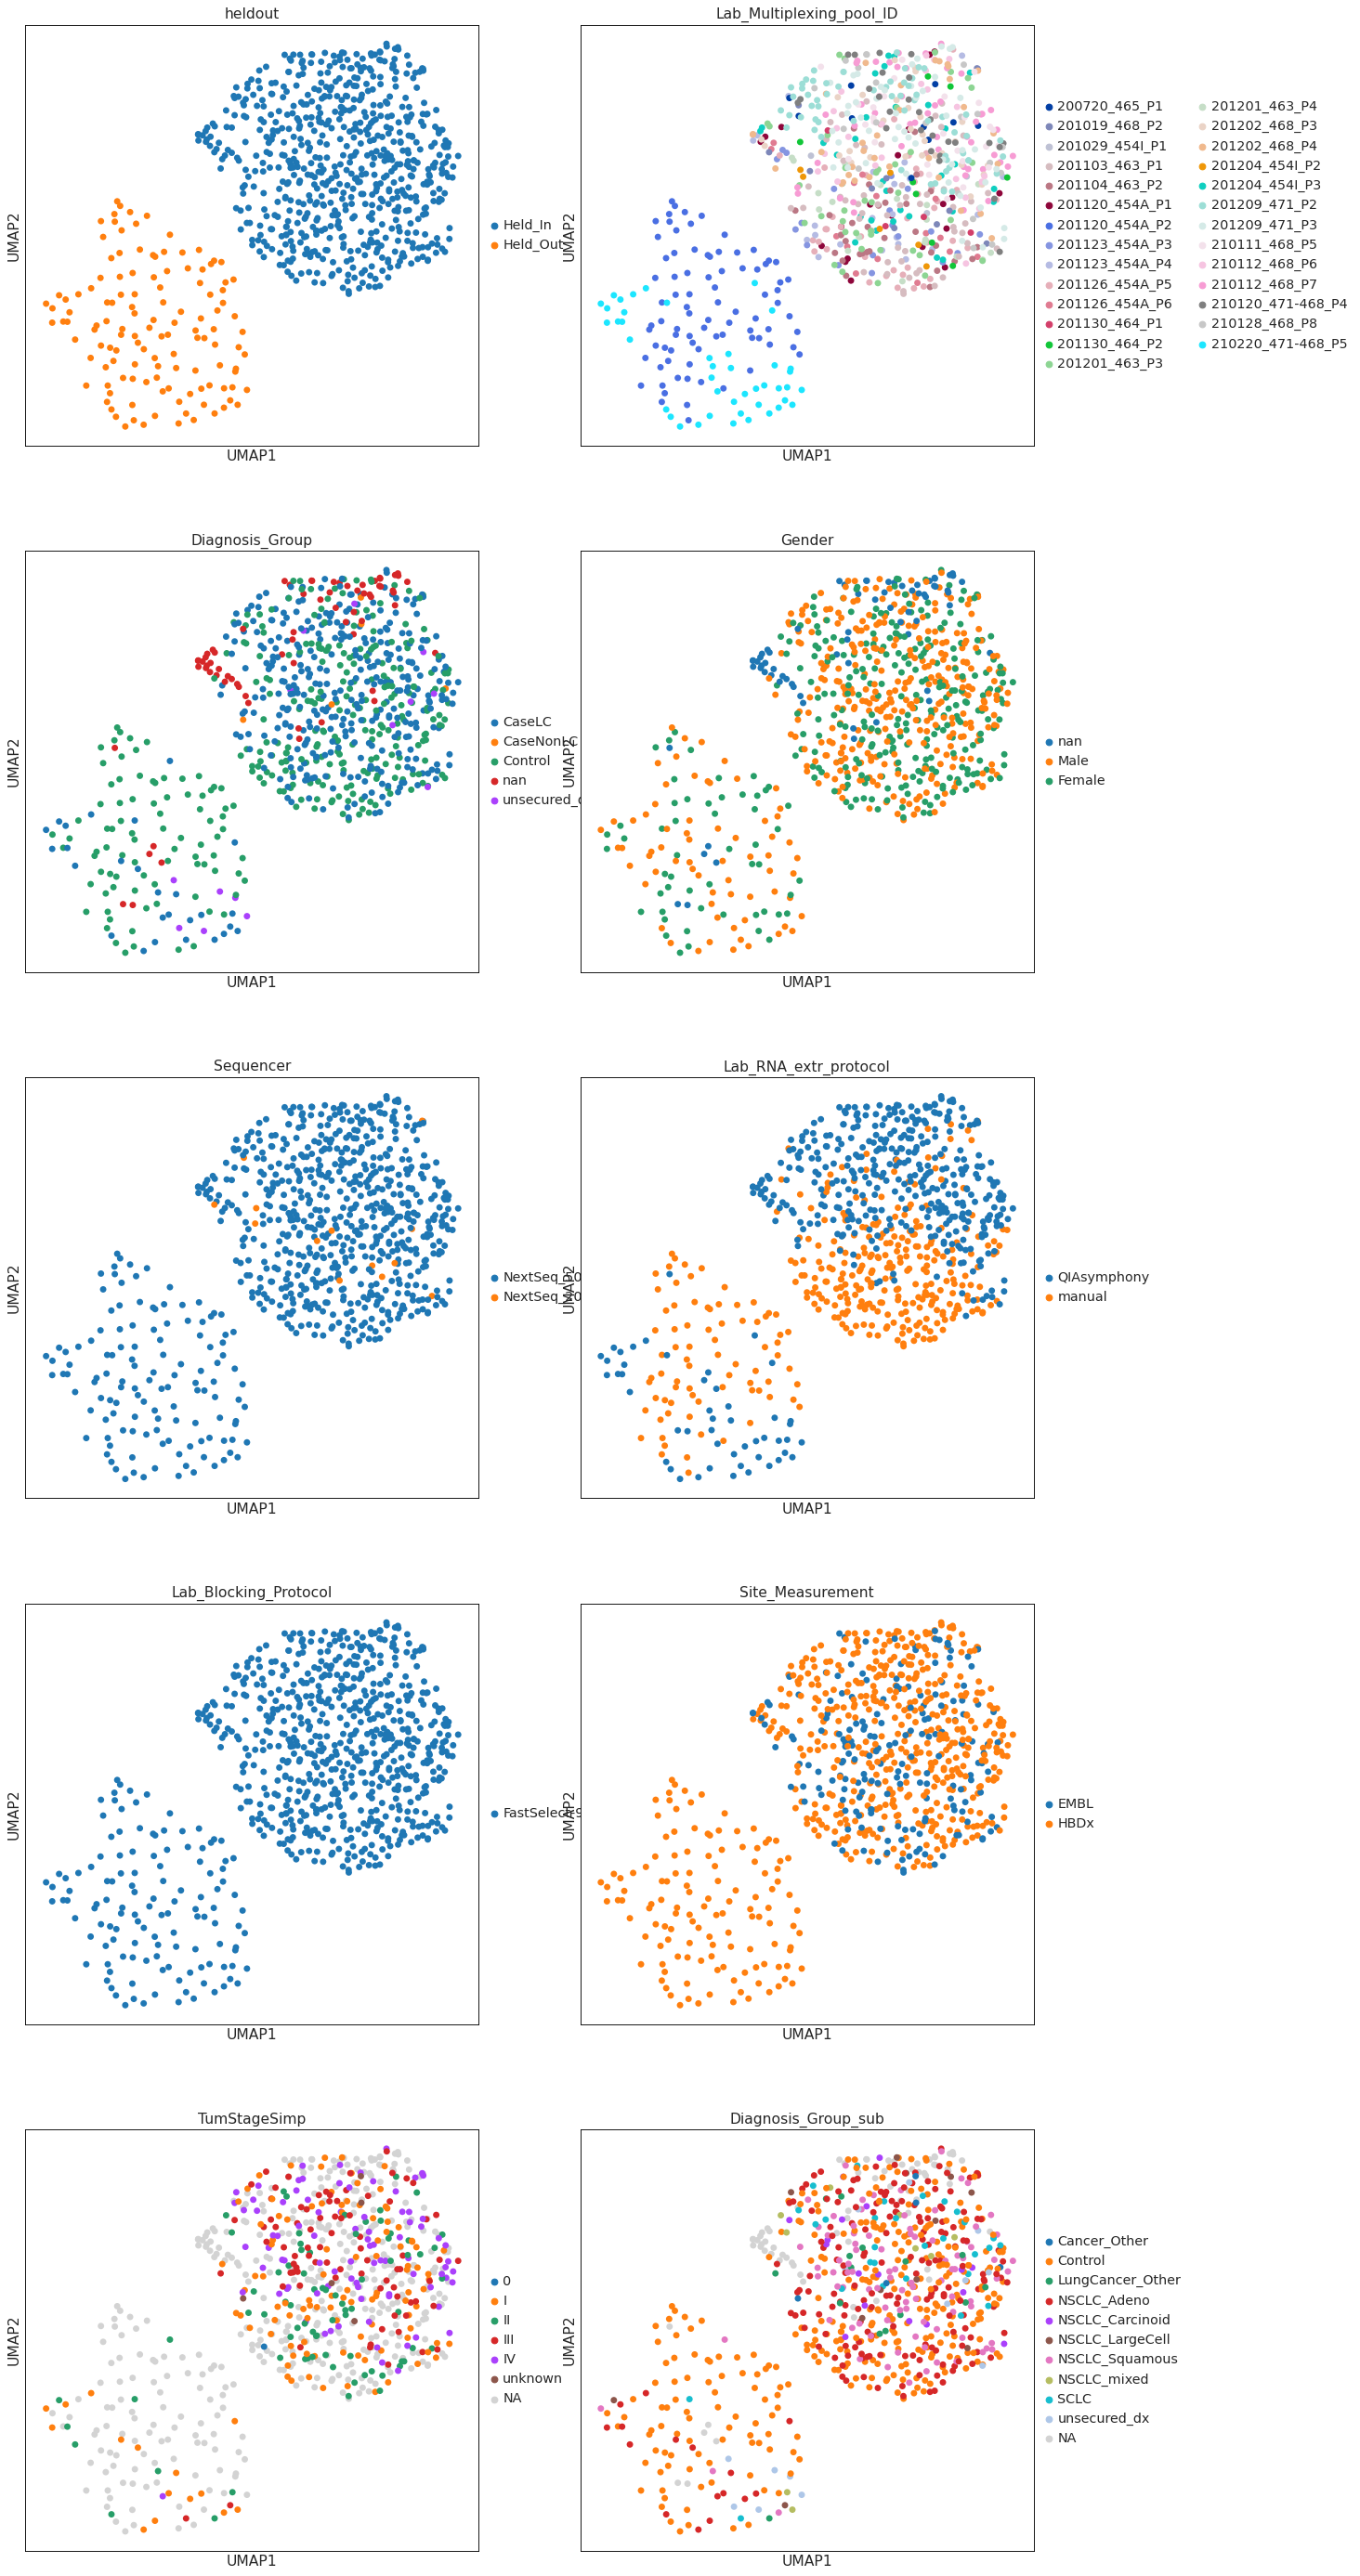

In [8]:

n_latent_vae = 10
# Filter out samples with less than count of 1, reduces samples from 1679 to 661!
sc.pp.filter_cells(ref_adata, min_counts=1)
categorical_covariate_keys=["Sequencer", "Lab_RNA_extr_protocol", "Sample_Group", "Gender", "Diagnosis_Group"]

"""
SCVI-tools requires your anndata to be setup in a specific way. This mainly consists of the categorical variables.
They need to be specified to batch, where the count data is and which are misc covariates.
However not all models actually use this information.
"""

for to_setup_adata in [ref_adata, new_adata]:
    scvi.data.setup_anndata(to_setup_adata, batch_key="batch", layer="counts", categorical_covariate_keys=categorical_covariate_keys)
    # scvi.data.setup_anndata(ref_adata, layer="counts")


scvi.data.transfer_anndata_setup(new_adata, ref_adata, extend_categories=True)
vae = scvi.model.SCVI(ref_adata, n_latent=n_latent_vae, n_layers=2)

print(vae.get_reconstruction_error(ref_adata))
vae.train(max_epochs = 1200, check_val_every_n_epoch=10, early_stopping=True)
print(vae.get_reconstruction_error(ref_adata))


vae_new_data = scvi.model.SCVI.load_query_data(new_adata, vae)
vae_new_data.train(max_epochs=0, plan_kwargs=dict(weight_decay=0.0))

latent_predicted = vae_new_data.get_latent_representation()
latent = vae_new_data.get_latent_representation(ref_adata)

ref_adata.obsm["X_scVI"] = latent
new_adata.obsm["X_scVI"] = latent_predicted

sc.pp.neighbors(ref_adata, use_rep="X_scVI")
sc.tl.umap(ref_adata)

sc.pp.neighbors(new_adata, use_rep="X_scVI")
sc.tl.umap(new_adata)

concated = ad.concat([ref_adata, new_adata])




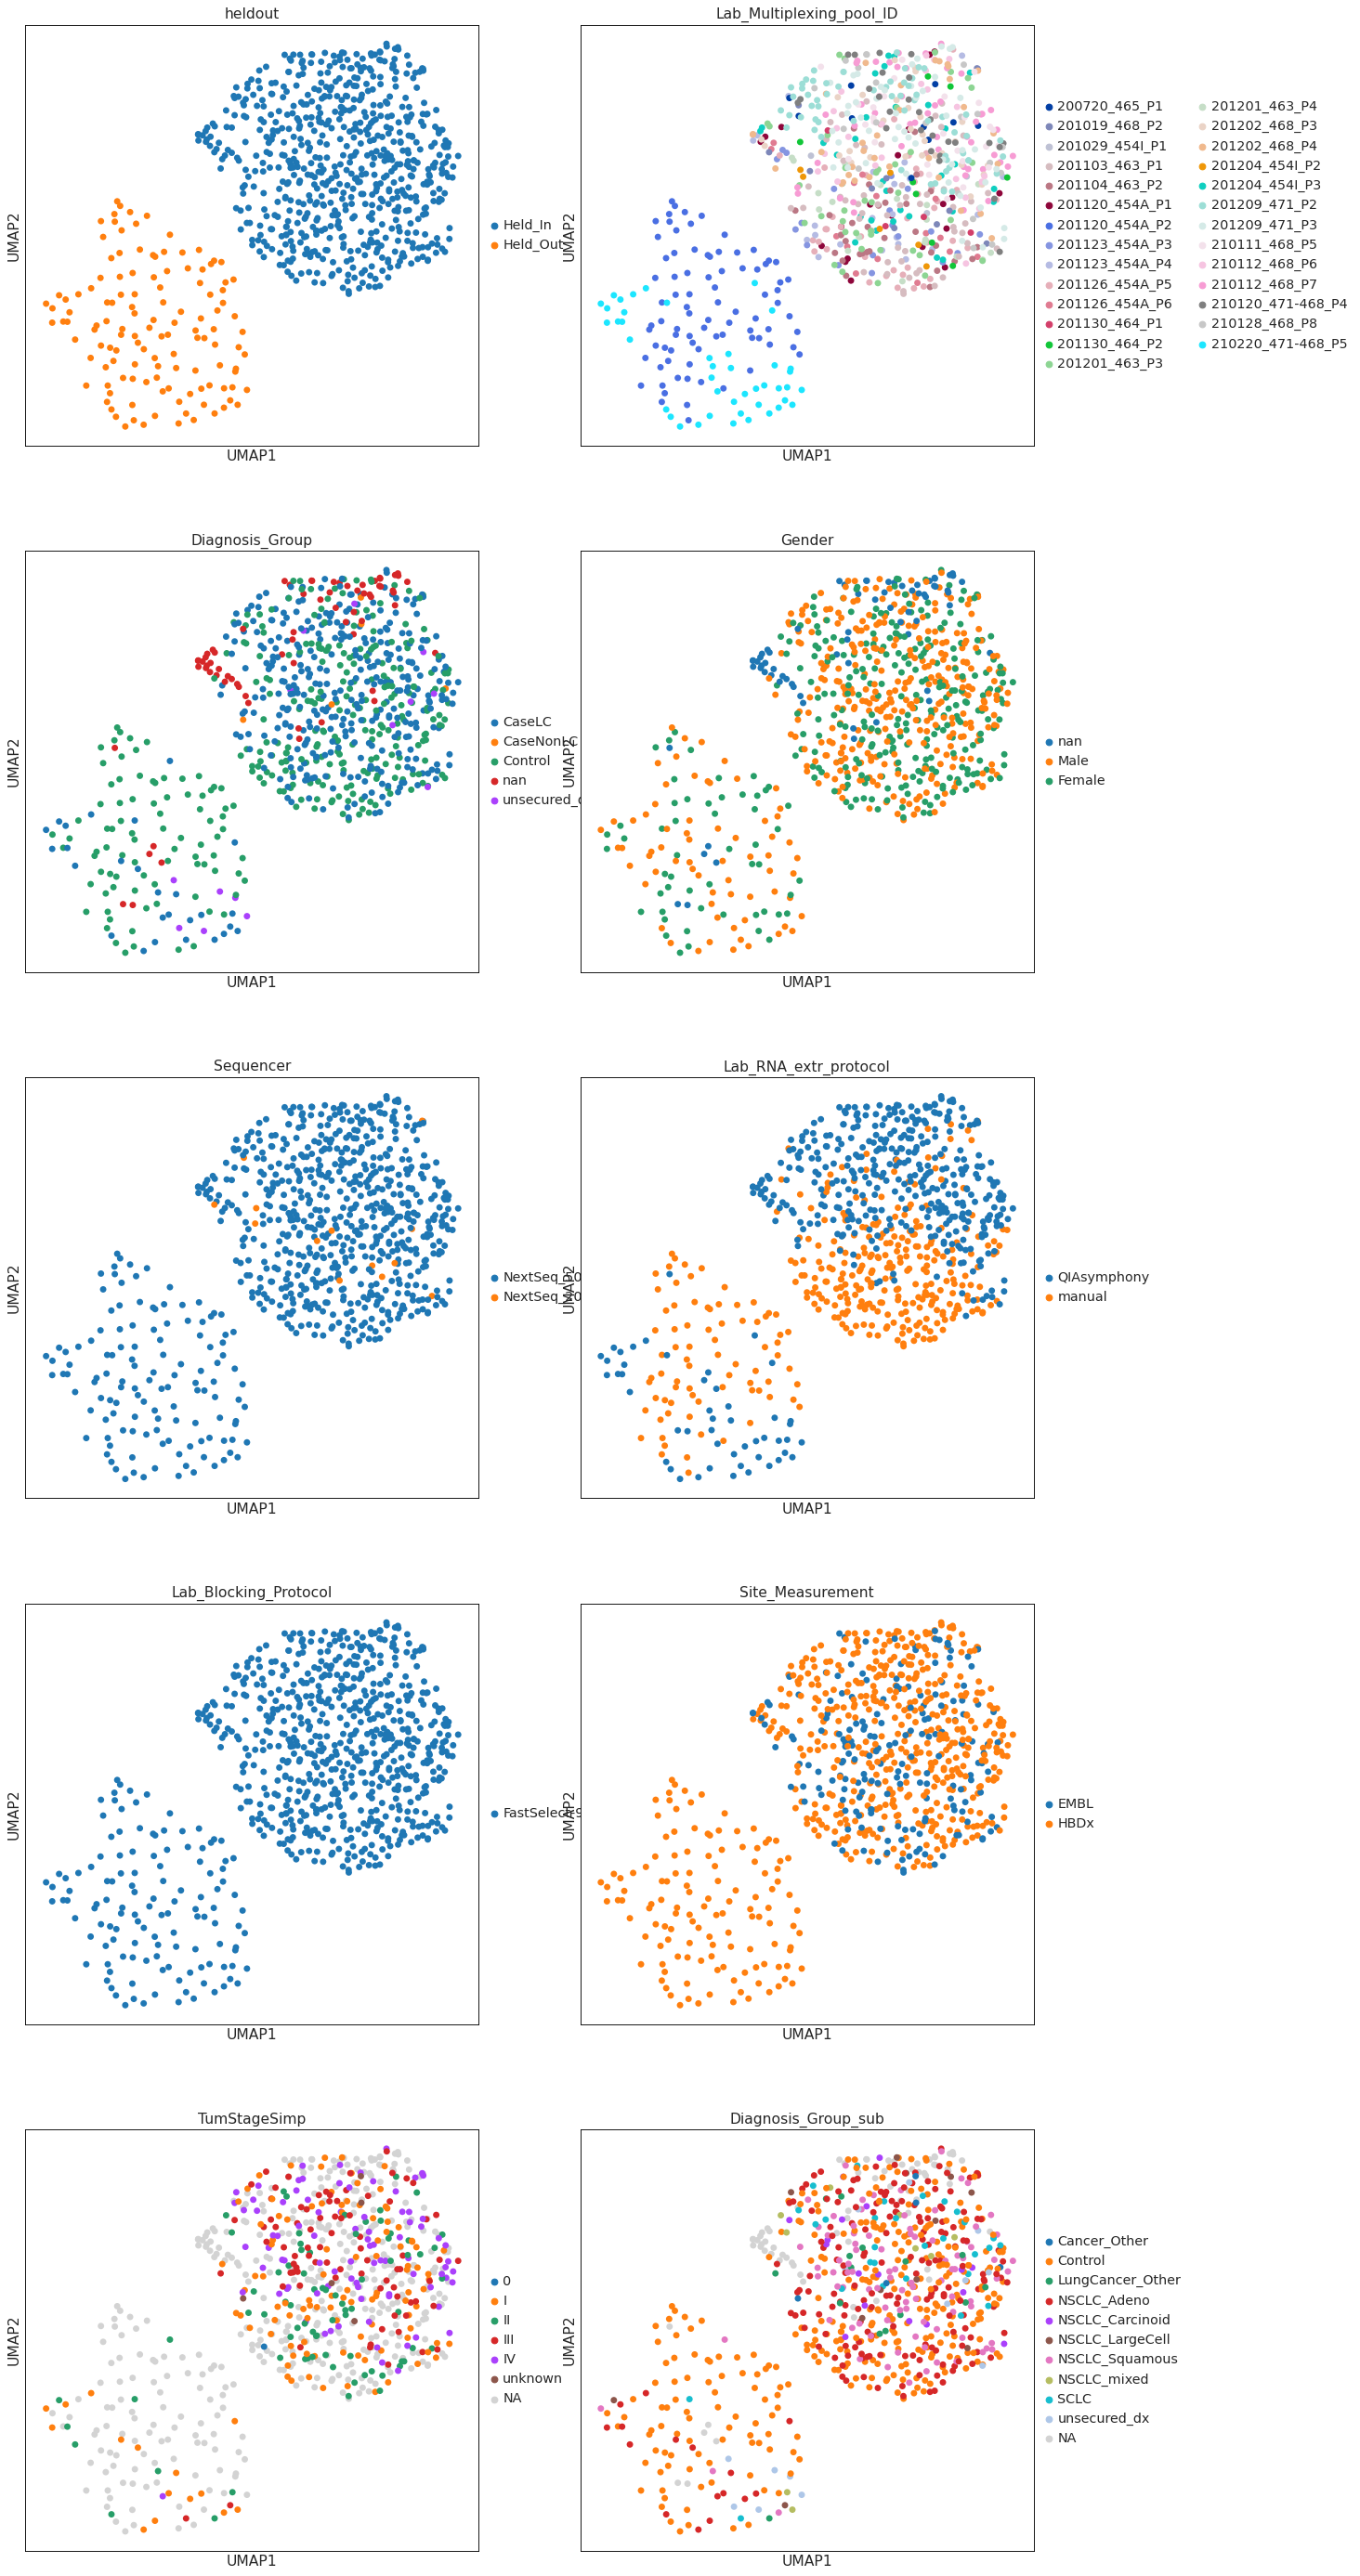

In [9]:
colors = ["heldout", "Lab_Multiplexing_pool_ID", 
                                        "Diagnosis_Group", 
                                        "Gender",
                                        "Sequencer",
                                        "Lab_RNA_extr_protocol", 
                                        "Lab_Blocking_Protocol",
                                        "Site_Measurement", 
                                        "TumStageSimp", 
                                        "Diagnosis_Group_sub"]

sc.pl.umap(concated, color=colors, ncols=2, use_raw=False)

## SCGen

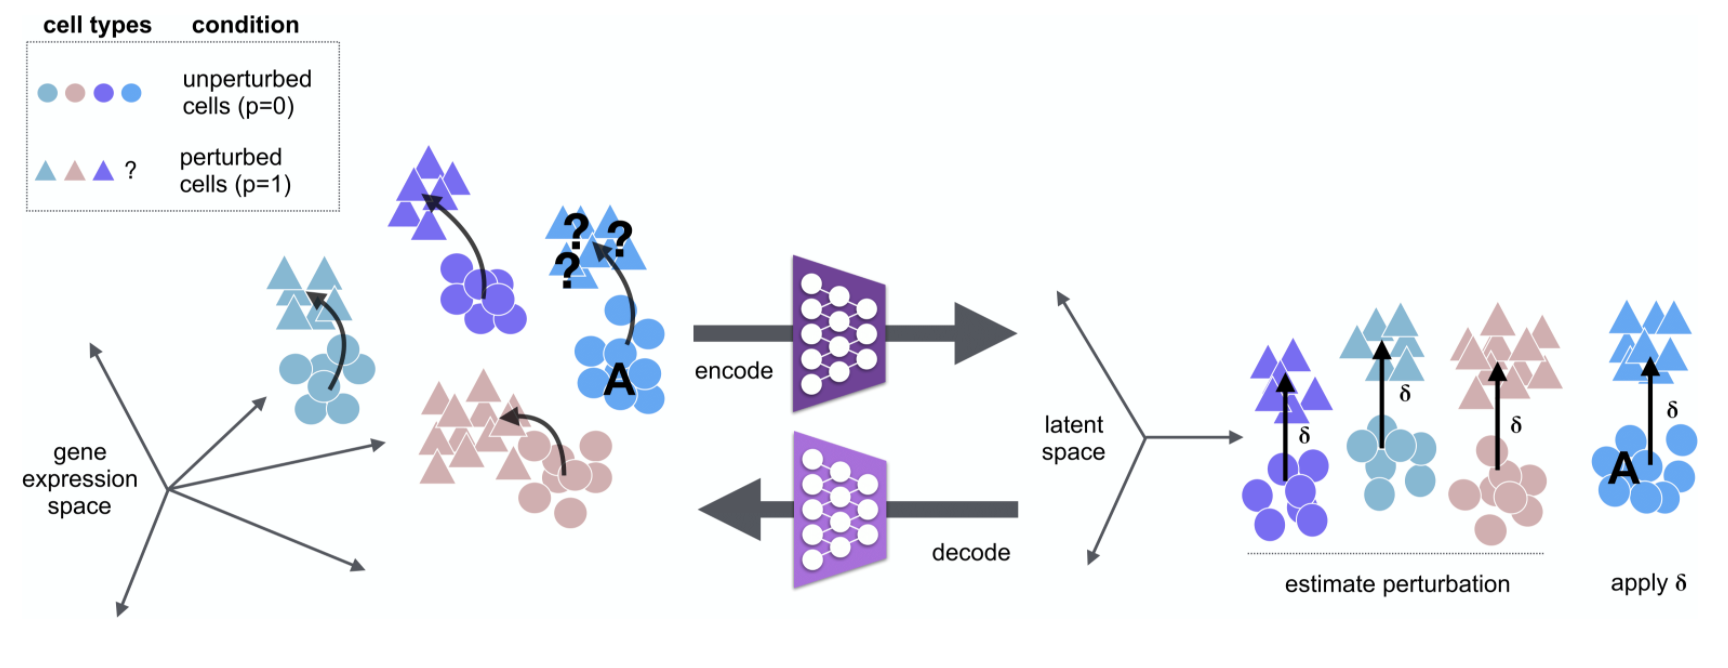

## AND NOW FOR SOMETHING COMPLETELY DIFFERENT

Batch **removed** using HVG selector?

local cache: /home/mah/.aws_cache False


Trying to set attribute `.obs` of view, copying.
/home/mah/conda/envs/hbdx/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/mah/conda/envs/hbdx/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Heldout batches are:  ['210120_471-468_P4' '201126_454A_P6']

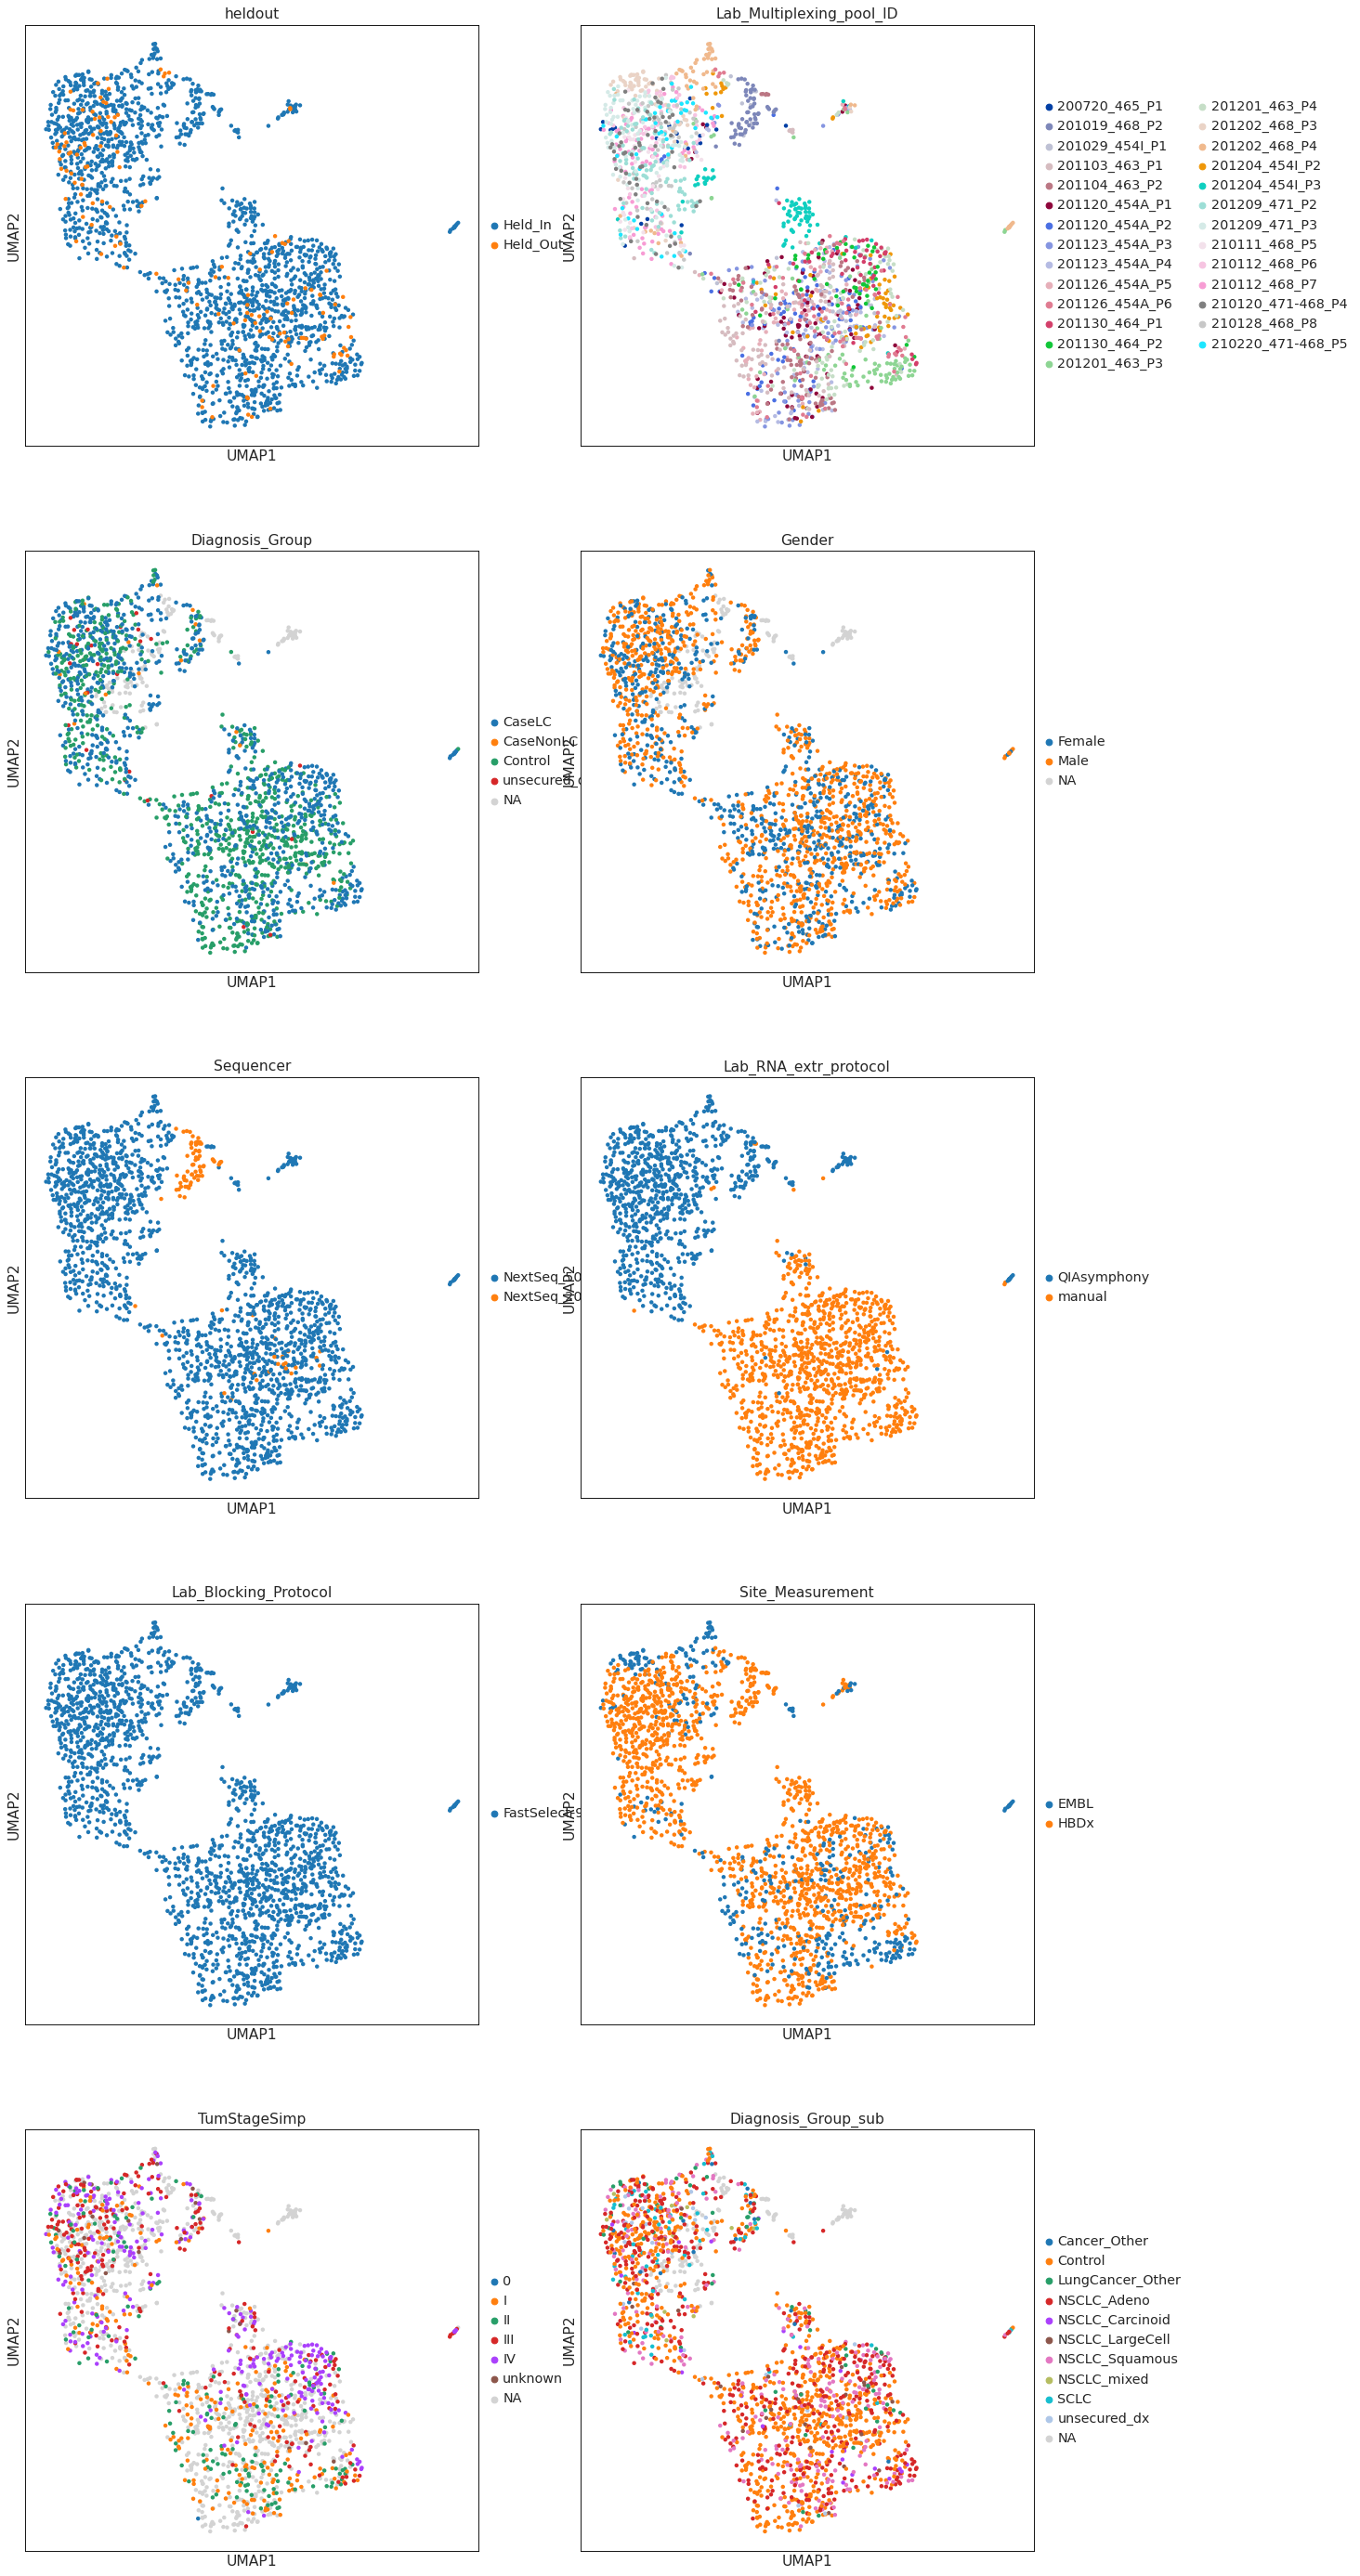

Heldout batches are:  ['210120_471-468_P4' '201126_454A_P6']

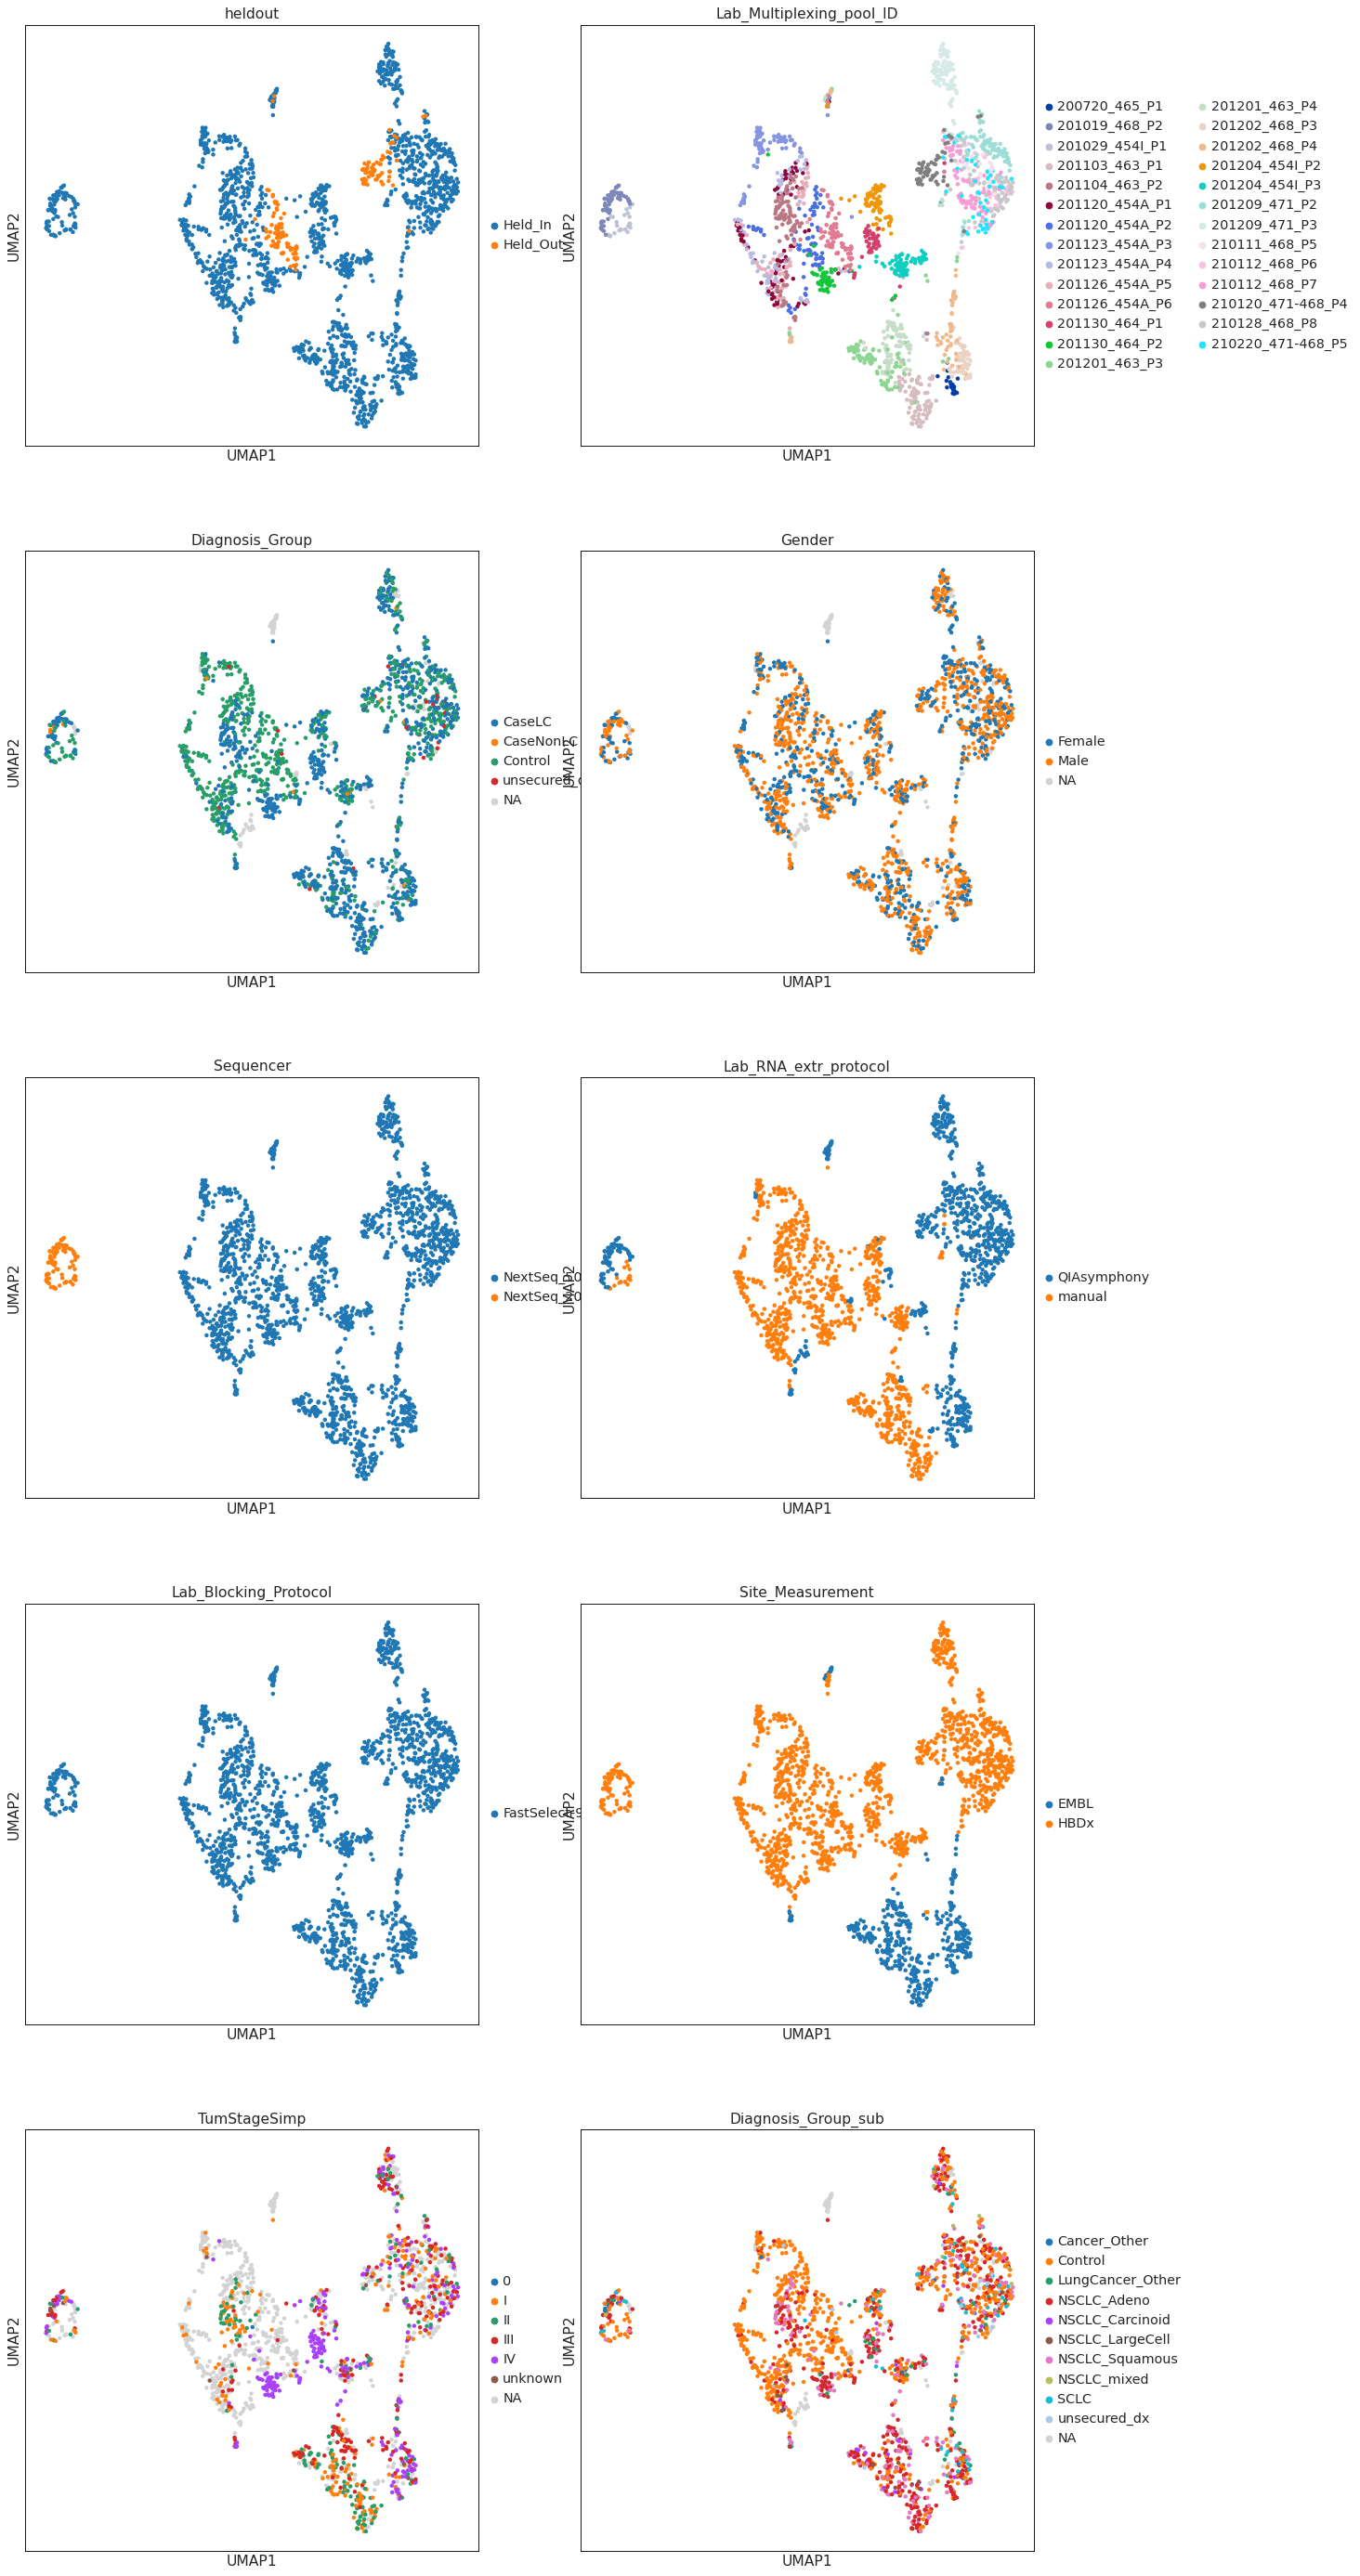

In [19]:
adata_path = "/data/hbdx/data/LC__ngs__rpm_log-21.5.0"

n_features = 2**14

adata = hbdx.io.load(adata_path)
adata.obs["batch"] = adata.obs["Lab_Multiplexing_pool_ID"].copy()

adata = filt(adata, "Lab_Multiplexing_pool_ID", 10)

holdout_batches = np.random.choice(adata.obs.batch.unique().categories, 2, replace=False)
adata.obs["heldout"] = np.where(adata.obs["batch"].isin(holdout_batches),"Held_Out", "Held_In")


for HVG_batch in [True, False]:
    ref_adata = adata[~adata.obs.batch.isin(holdout_batches),:]
    ref_adata = ref_adata.copy()
    sc.pp.calculate_qc_metrics(ref_adata, inplace=True)
    ref_adata = ref_adata[ref_adata.obs.n_genes_by_counts > 5, :] # filtering out low gene count
    ref_adata = ref_adata.copy()
    if HVG_batch:
        ref_adata = hbdx.pipeline.HVGSelector(n_top_genes=n_features, batch_key="batch").fit_transform(ref_adata)
    else: 
        ref_adata = hbdx.pipeline.HVGSelector(n_top_genes=n_features).fit_transform(ref_adata)
    sc.pp.scale(ref_adata)


    new_adata = adata[adata.obs.batch.isin(holdout_batches), :]
    new_adata = new_adata.copy()
    new_adata = new_adata[:, ref_adata.var_names]
    new_adata = new_adata.copy()
    sc.pp.scale(new_adata)


    print("Heldout batches are: ", holdout_batches)


    concated = ad.concat([ref_adata, new_adata])
    sc.tl.pca(concated)
    sc.pp.neighbors(concated, use_rep="X_pca")
    sc.tl.umap(concated)

    colors = ["heldout", "Lab_Multiplexing_pool_ID", 
                                            "Diagnosis_Group", 
                                            "Gender",
                                            "Sequencer",
                                            "Lab_RNA_extr_protocol", 
                                            "Lab_Blocking_Protocol",
                                            "Site_Measurement", 
                                            "TumStageSimp", 
                                            "Diagnosis_Group_sub"]

    # Anndata raw, no VAE or scaling or preprocessing or HVG selection

    sc.pl.umap(concated, color=colors, ncols=2, use_raw=False)
